<a href="https://colab.research.google.com/github/AkshathaNapanda/Classifying-Cybersecurity-Incidents-with-ML/blob/main/Classifying_CI_with_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
train_path = '/content/drive/MyDrive/new_train_sample.csv'
test_path = '/content/drive/MyDrive/GUIDE_Test.csv'
df_train = pd.read_csv(train_path, low_memory=False)
df_test = pd.read_csv(test_path, low_memory=False)

In [3]:
# Step 3: Data Exploration
from tabulate import tabulate

print("Training Data Overview:")
print(tabulate(df_train.head(), headers='keys', tablefmt='pretty'))
print("\nTest Data Overview:")
print(tabulate(df_test.head(), headers='keys', tablefmt='pretty'))


Training Data Overview:
+---+------------+---------------+-------+------------+---------+--------------------------+------------+------------+--------------------+-----------------------------------------------------------------+----------------+---------------+----------------+------------+--------------+----------+--------+-----------+--------+------------+------------+-----------------+-------------+------------+------------------+----------------+-------------+-------------------+-------------------+---------------+-----------------+--------------------+--------------+----------+------------+----------------+--------------+-------------+----------+-----------+-------------------+----------------+-------------+-------------+-------+-------+
|   | Unnamed: 0 |      Id       | OrgId | IncidentId | AlertId |        Timestamp         | DetectorId | AlertTitle |      Category      |                         MitreTechniques                         | IncidentGrade  | ActionGrouped | ActionG

In [4]:
# Step 4: Data Preprocessing
# Dropping unnecessary columns
df_train.drop(columns=['Unnamed: 0'], errors='ignore', inplace=True)
df_test.drop(columns=['Unnamed: 0'], errors='ignore', inplace=True)



In [5]:
# Dropping columns with too many missing values (threshold = 50% missing)
thresh = len(df_train) * 0.5
df_train.dropna(thresh=thresh, axis=1, inplace=True)
df_test.dropna(thresh=thresh, axis=1, inplace=True)

In [6]:
# Selecting target column automatically
target_column = df_train.columns[-1]
print(f"Automatically selected target column: {target_column}")

Automatically selected target column: City


In [7]:
# Handling missing values
numeric_cols = df_train.select_dtypes(include=['number']).columns.intersection(df_test.columns)
categorical_cols = df_train.select_dtypes(exclude=['number']).columns.intersection(df_test.columns)

df_train[numeric_cols] = df_train[numeric_cols].fillna(df_train[numeric_cols].median())
df_train[categorical_cols] = df_train[categorical_cols].fillna(df_train[categorical_cols].mode().iloc[0])

df_test[numeric_cols] = df_test[numeric_cols].fillna(df_test[numeric_cols].median())
df_test[categorical_cols] = df_test[categorical_cols].fillna(df_test[categorical_cols].mode().iloc[0])

In [8]:
# Encoding categorical variables
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
if df_train[target_column].dtype == 'object' or df_train[target_column].nunique() < 20:
    df_train[target_column] = label_enc.fit_transform(df_train[target_column])
    df_test[target_column] = df_test[target_column].map(lambda x: x if x in label_enc.classes_ else label_enc.classes_[0])
    df_test[target_column] = label_enc.transform(df_test[target_column])

In [9]:
# Feature & target selection
X = df_train.drop(columns=[target_column])
y = df_train[target_column]
X_test = df_test.drop(columns=[target_column], errors='ignore')

In [10]:
# Step 5: Optimized Data Preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Drop unnecessary columns (timestamps, IDs, etc.)
timestamp_cols = ['Timestamp', 'CreatedAt', 'UpdatedAt']  # Adjust based on dataset
df_train.drop(columns=[col for col in timestamp_cols if col in df_train.columns], inplace=True)
df_test.drop(columns=[col for col in timestamp_cols if col in df_test.columns], inplace=True)

# Ensure target column is correctly identified
target_column = "IncidentGrade"  # Replace with the actual target column
if target_column not in df_train.columns:
    raise ValueError(f"Target column '{target_column}' not found in dataset!")

# Convert target to categorical labels
label_enc = LabelEncoder()
df_train[target_column] = label_enc.fit_transform(df_train[target_column])
df_test[target_column] = label_enc.transform(df_test[target_column])

# Identify categorical columns
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()

# Encode categorical features
for col in categorical_cols:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

# Feature and target selection
X = df_train.drop(columns=[target_column])  # Features
y = df_train[target_column]  # Target

X_test = df_test.drop(columns=[target_column], errors='ignore')

# Debugging: Check data types
print("Data types after encoding:\n", X.dtypes)

# Step 6: Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 7: Model Training with XGBoost
from xgboost import XGBClassifier
import gc

gc.collect()  # Free memory

model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    tree_method="hist",
    use_label_encoder=False,
    eval_metric="mlogloss"
)

model.fit(X_train, y_train)

print(" Model training completed successfully!")

# Step 8: Save the trained model
model_path = "/content/drive/MyDrive/xgboost_model.json"  # Update the path as needed
model.save_model(model_path)
print(f" Model saved successfully at: {model_path}")


Data types after encoding:
 Id                    int64
OrgId                 int64
IncidentId            int64
AlertId               int64
DetectorId            int64
AlertTitle            int64
Category              int64
EntityType            int64
EvidenceRole          int64
DeviceId              int64
Sha256                int64
IpAddress             int64
Url                   int64
AccountSid            int64
AccountUpn            int64
AccountObjectId       int64
AccountName           int64
DeviceName            int64
NetworkMessageId      int64
RegistryKey           int64
RegistryValueName     int64
RegistryValueData     int64
ApplicationId         int64
ApplicationName       int64
OAuthApplicationId    int64
FileName              int64
FolderPath            int64
ResourceIdName        int64
OSFamily              int64
OSVersion             int64
CountryCode           int64
State                 int64
City                  int64
dtype: object


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:39:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Model training completed successfully!
 Model saved successfully at: /content/drive/MyDrive/xgboost_model.json


 Macro-F1 Score: 0.8445

 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.97      0.87    416110
           1       0.93      0.69      0.79    203156
           2       0.94      0.82      0.88    332418

    accuracy                           0.86    951684
   macro avg       0.88      0.83      0.84    951684
weighted avg       0.87      0.86      0.85    951684



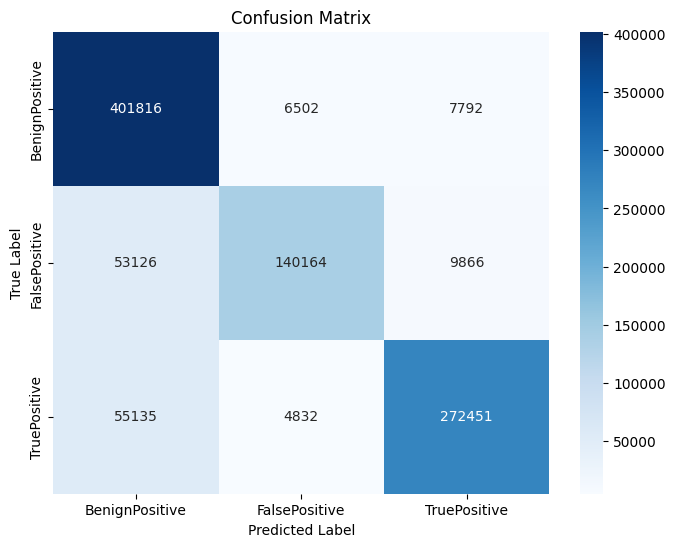

In [11]:
# Step 8: Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Predict on validation set
y_pred = model.predict(X_val)

# Compute Macro-F1 Score
macro_f1 = f1_score(y_val, y_pred, average='macro')
print(f" Macro-F1 Score: {macro_f1:.4f}")

# Generate full classification report
print("\n Classification Report:\n", classification_report(y_val, y_pred))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


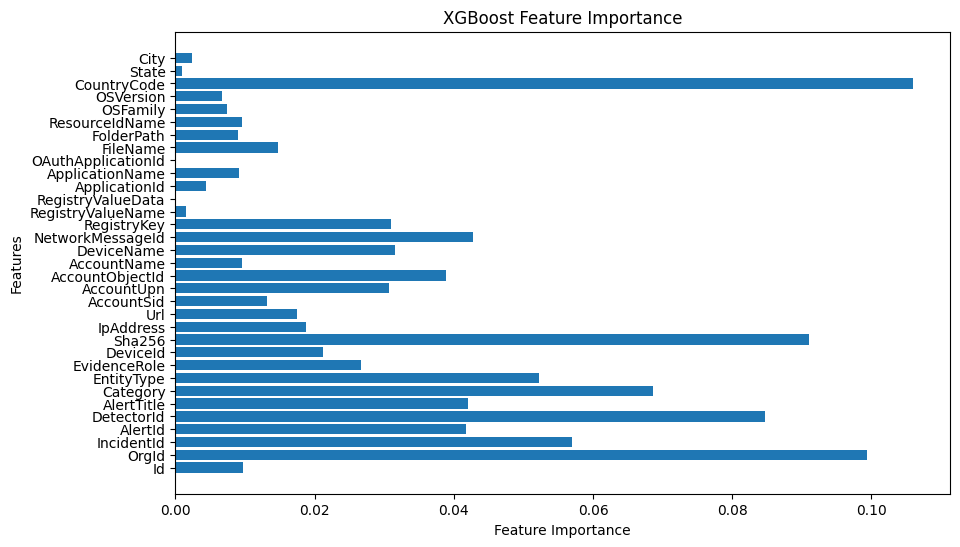

In [12]:
import matplotlib.pyplot as plt
import numpy as np

#  Feature Importance Analysis
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(model.feature_importances_)), model.feature_importances_)
plt.yticks(np.arange(len(X_train.columns)), X_train.columns)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.show()

<Figure size 640x480 with 0 Axes>

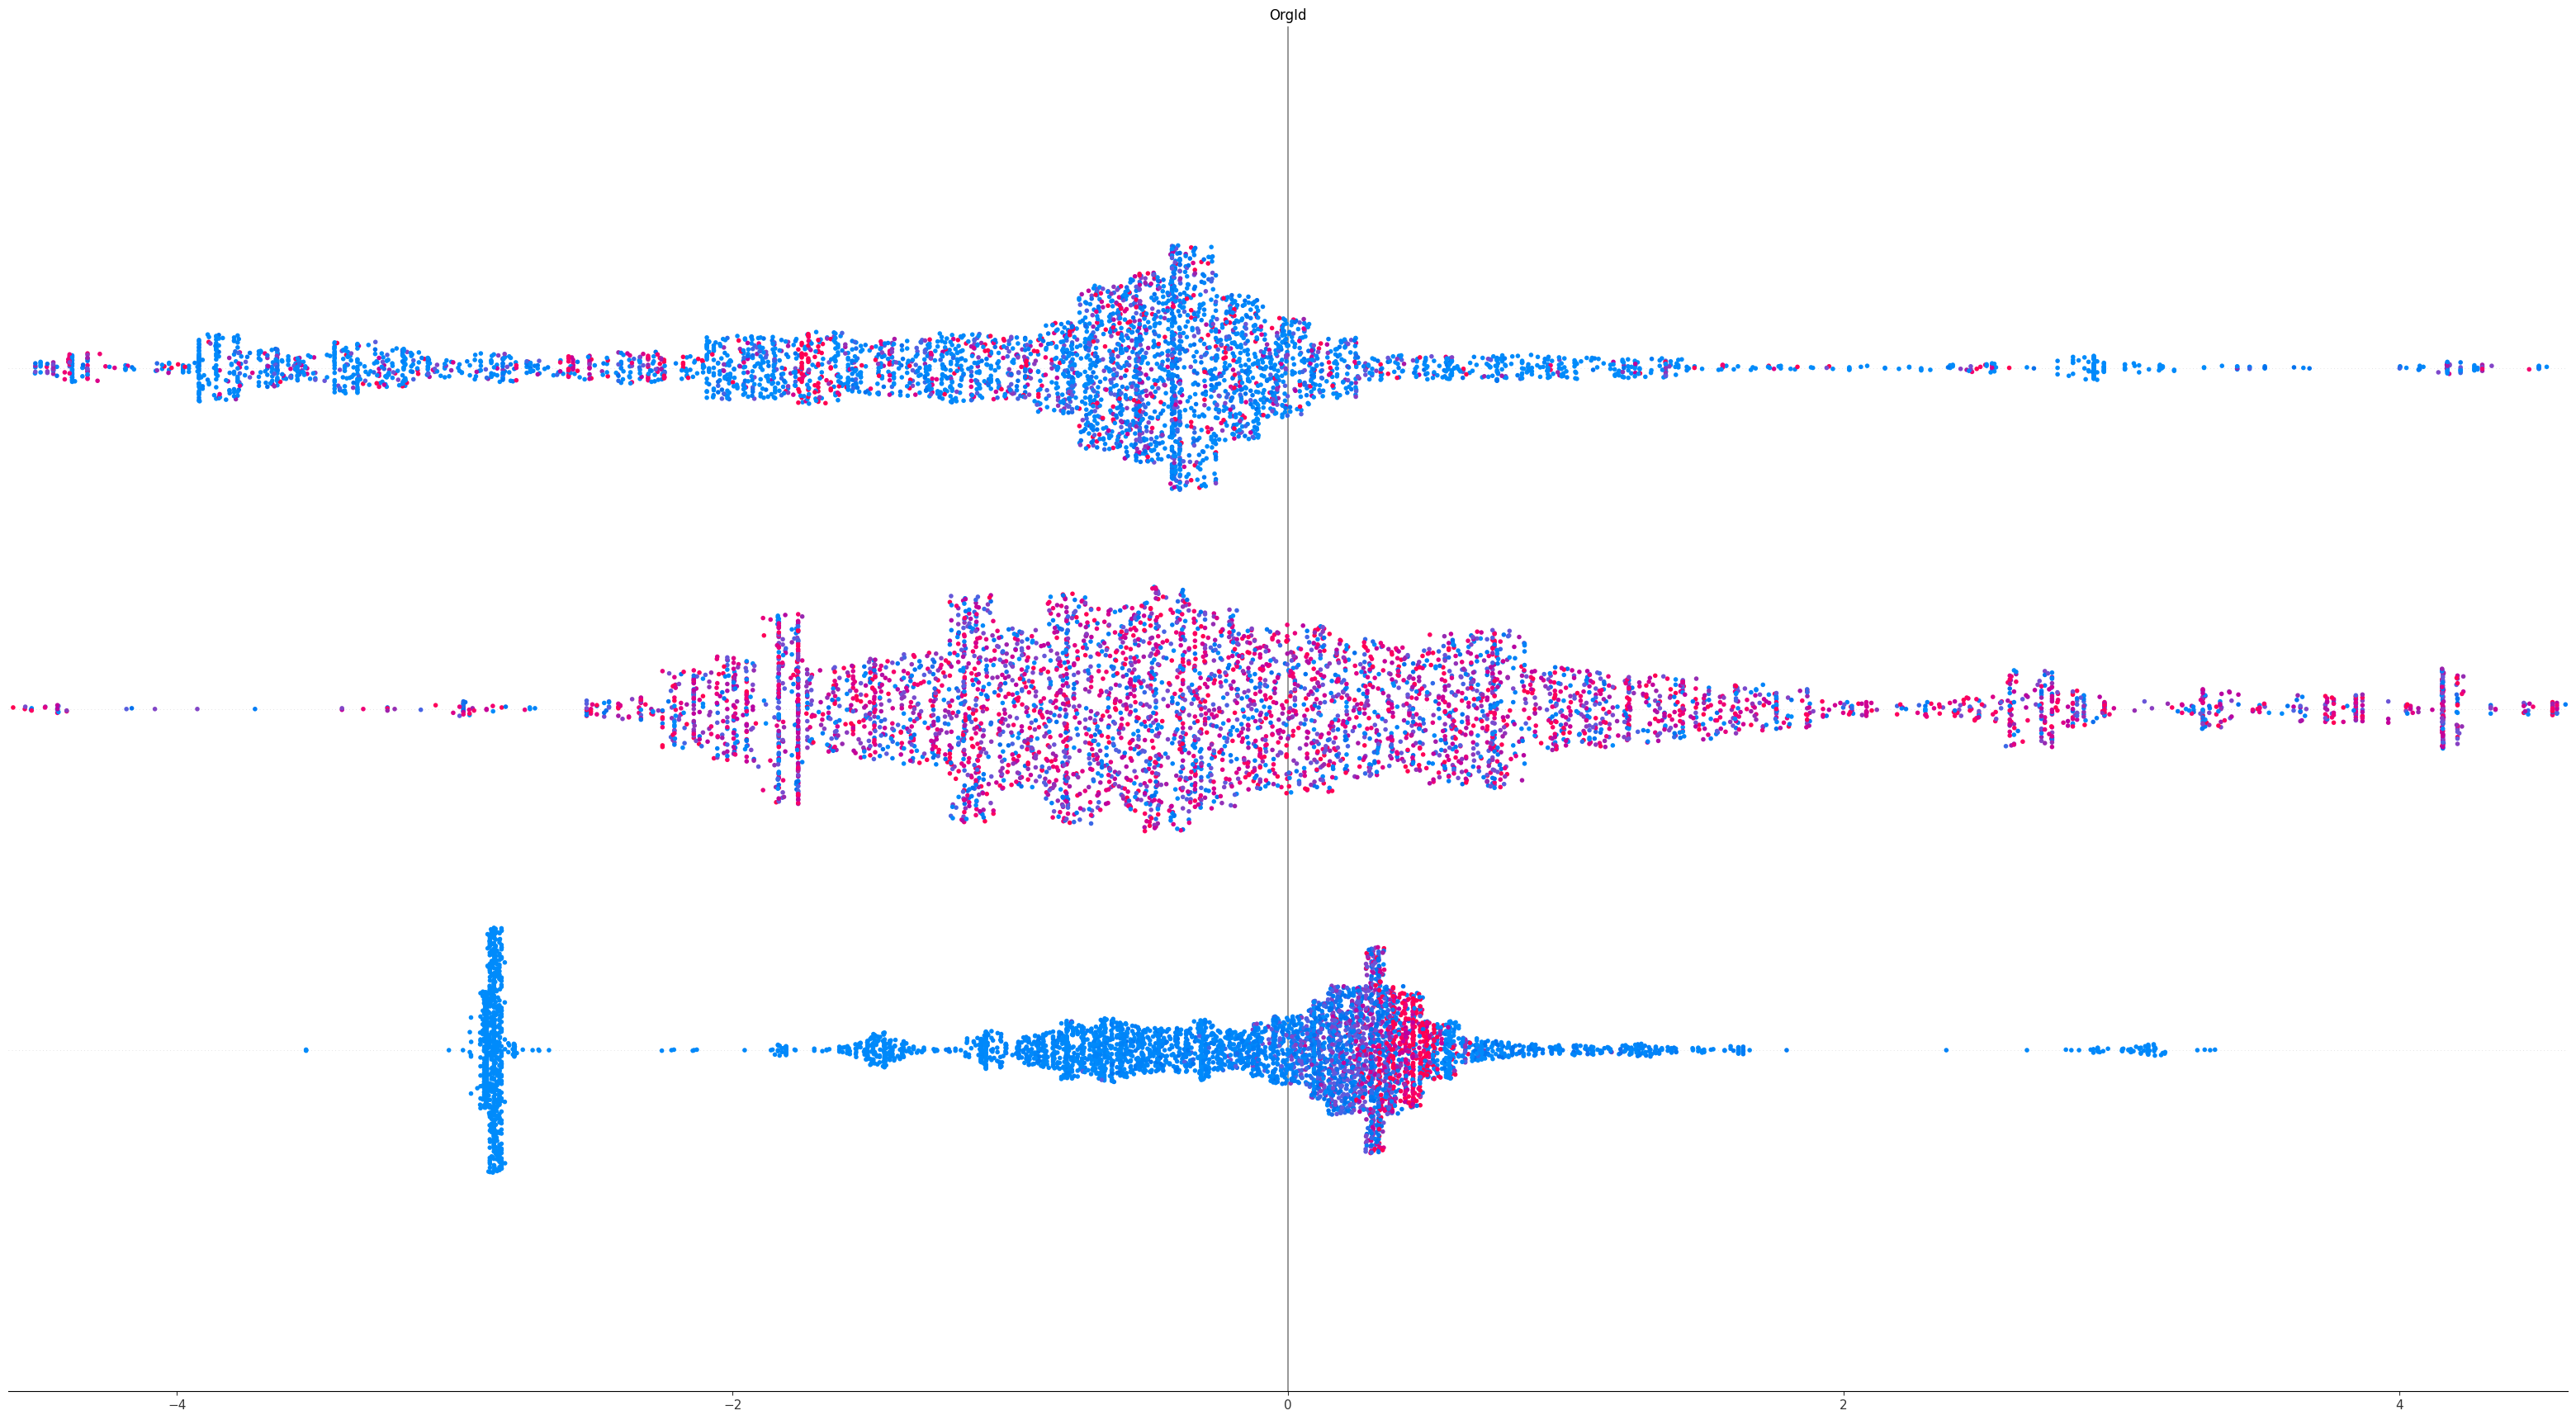

In [13]:
import shap

# Ensure X_val is defined
X_sample = X_val.sample(n=5000, random_state=42)  # Adjust sample size as needed

# Use approximate=True for faster SHAP computation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample, check_additivity=False, approximate=True)

# Limit number of features displayed for efficiency
shap.summary_plot(shap_values, X_sample, max_display=20)  # Adjust max_display as needed


In [14]:
# Ensure X_test has the same columns as X_train
missing_cols = set(X_train.columns) - set(X_test.columns)
extra_cols = set(X_test.columns) - set(X_train.columns)

# Drop extra columns from X_test
X_test = X_test.drop(columns=extra_cols, errors='ignore')

# Add missing columns with default values (zero or mode for categorical)
for col in missing_cols:
    if col in X_train.select_dtypes(include=['number']).columns:
        X_test[col] = 0  # Default numerical values
    else:
        X_test[col] = X_train[col].mode()[0]  # Default categorical values

# Ensure the order of columns matches exactly
X_test = X_test[X_train.columns]

print(" X_test matches X_train in terms of columns.")


 X_test matches X_train in terms of columns.


In [15]:
# Predict on the corrected test data
y_test_pred = model.predict(X_test)

print("Test set predictions completed successfully!")


Test set predictions completed successfully!


In [16]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Compute Macro-F1, Precision, and Recall
macro_f1_test = f1_score(df_test[target_column], y_test_pred, average='macro')
precision_test = precision_score(df_test[target_column], y_test_pred, average='macro')
recall_test = recall_score(df_test[target_column], y_test_pred, average='macro')

# Display Performance Metrics
print(f"\nTest Set Performance Metrics:")
print(f"Macro-F1 Score: {macro_f1_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")

# Detailed Classification Report
print("\nTest Set Classification Report:\n", classification_report(df_test[target_column], y_test_pred))



Test Set Performance Metrics:
Macro-F1 Score: 0.8318
Precision: 0.8622
Recall: 0.8169

Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.94      0.85   1752940
           1       0.88      0.69      0.77    902698
           2       0.93      0.82      0.87   1492354

    accuracy                           0.84   4147992
   macro avg       0.86      0.82      0.83   4147992
weighted avg       0.85      0.84      0.84   4147992



In [17]:
print("\nPerformance Comparison (Validation vs Test):")
print(f"Macro-F1 Score: Validation={macro_f1:.4f} | Test={macro_f1_test:.4f}")
print(f"Precision: Validation={precision_score(y_val, y_pred, average='macro'):.4f} | Test={precision_test:.4f}")
print(f"Recall: Validation={recall_score(y_val, y_pred, average='macro'):.4f} | Test={recall_test:.4f}")



Performance Comparison (Validation vs Test):
Macro-F1 Score: Validation=0.8445 | Test=0.8318
Precision: Validation=0.8840 | Test=0.8622
Recall: Validation=0.8251 | Test=0.8169
